In [ ]:
!unzip drive/MyDrive/dataset_zurich.zip

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!rm -rf __MACOSX

In [ ]:
!pip install -U xgboost  # Upgrade to be able to access dask.
import xgboost as xgb
# from sklearn.externals.joblib import parallel_backend ## DEPRECATED!

     |████████████████████████████████| 166.7 MB 17 kB/s 
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


In [4]:
import os

import numpy as np
import matplotlib.pyplot as plt

import cv2

# import dask.dataframe as dd
# import dask.array as da
# import dask_image.imread

In [5]:
def generate_data(category):
  """Combine files from folders and generate a single numpy array.

  category: Which category, train, valid, or test data to create.
  Either of "test", "validation", "training".

  """
  data = []
  labels = []
  root_dir = "dataset_zurich"
  classes = ["merger", "noninteracting"]
  for class_ in classes:
    class_category_path = os.path.join(root_dir, class_, category)
    img_paths = os.listdir(class_category_path)
    for img_path in img_paths:
      img = cv2.imread(os.path.join(class_category_path, img_path))
      img = cv2.resize(img, (100, 100)).mean(axis=2).flatten()
      labels.append(1) if class_ == "merger" else labels.append(0)
      data.append(img)
  return np.array(data), np.array(labels)

In [6]:
train_data, train_labels = generate_data("training")

In [7]:
valid_data, valid_labels = generate_data("validation")

In [8]:
test_data, test_labels = generate_data("test")

In [ ]:
import xgboost as xgb

In [ ]:
train = xgb.DMatrix(train_data, label=train_labels)
valid = xgb.DMatrix(valid_data, label=train_labels)
test = xgb.DMatrix(test_data, label=test_labels)

In [13]:
# Define parameters for XGBoost classifier.
params = {}

# The values have been selected using cross validation on a subset of the data. Analysis in cv_analysis.md.

# Booster parameters
params["eta"]              = 0.01 # Learning rate
params["max_depth"]        = 12  # Maximum depth of tree
params["subsample"]        = 0.8 # Fraction of events to train the tree on
params["colsample_bytree"] = 0.8 # Fraction of features to train the tree on
params["min_child_weight"] = 13 # Minimum weight required to create a new node in the tree

# Learning parameters
params["objective"]   = "binary:logistic" # Objective function (two classes for which a score needs to be output)
params["eval_metric"] = "error"           # Evaluation metric for cross validation
params = dict(list(params.items()) + [("eval_metric", "log-loss"), ("eval_metric", "rmse")])

In [ ]:
num_trees = 300
booster = xgb.train(params, train, num_boost_round=num_trees) # Took 18min 44s

In [ ]:
model_path = "xgbbost_model.txt"
booster.save_model(fname=model_path)

In [ ]:
predictions = booster.predict(test)

In [ ]:
predictions

array([0.8725305 , 0.5964308 , 0.9526348 , ..., 0.43646064, 0.18802957,
       0.10943499], dtype=float32)

In [ ]:
evaluation = booster.eval(test)
evaluation

'[0]\teval-rmse:0.296336'

In [ ]:
def plot_predictions(predictions, test):
  """Plot a histogram of predictions by the model, both combined and class wise.
  Parameters
  ----------
  predictions: ~np.array
    Predictions from the model
  test: ~xgboost.core.DMatrix
    The testing dataset
  Returns
  -------
  Prediction plot
  """
  import matplotlib.pyplot as plt

  fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(30, 10));

  hist_style_all = dict(histtype="step", color="darkgreen", label="All events")
  hist_style_sig = dict(histtype="step", color="midnightblue", label="merger")
  hist_style_bkg = dict(histtype="step", color="firebrick", label="noninteracting")

  ax1.hist(predictions, bins=np.linspace(0, 1, 50), **hist_style_all);

  ax1.set_xlabel("Prediction probabilties", fontsize=16);
  ax1.set_ylabel("No. of instances", fontsize=16);
  ax1.set_title("Combined");
  ax1.legend(frameon=False);

  ax2.hist(predictions[test.get_label().astype(bool)], bins=np.linspace(0, 1, 50),
          **hist_style_sig);
  ax2.hist(predictions[~(test.get_label().astype(bool))], bins=np.linspace(0, 1, 50),
          **hist_style_bkg);

  ax2.set_xlabel("Prediction probabilties", fontsize=16);
  ax2.set_ylabel("No. of instances", fontsize=16);
  ax2.set_title("Individual")
  ax2.legend(frameon=False);


def plot_roc(predictions, test):
  import matplotlib.pyplot as plt
  try:
    from plot_metric.functions import BinaryClassification
  except ImportError:
    raise ValueError("Error while import! Cannot import `BinaryClassification from` `plot_metric.functions`. "
          "Use 'pip install plot-metric' to solve this error.")
  
  # Visualisation with plot_metric
  bc = BinaryClassification(test.get_label(), predictions, labels=["Class 1", "Class 2"])

  # Figures
  plt.figure(figsize=(10,10))
  bc.plot_roc_curve()
  plt.show()

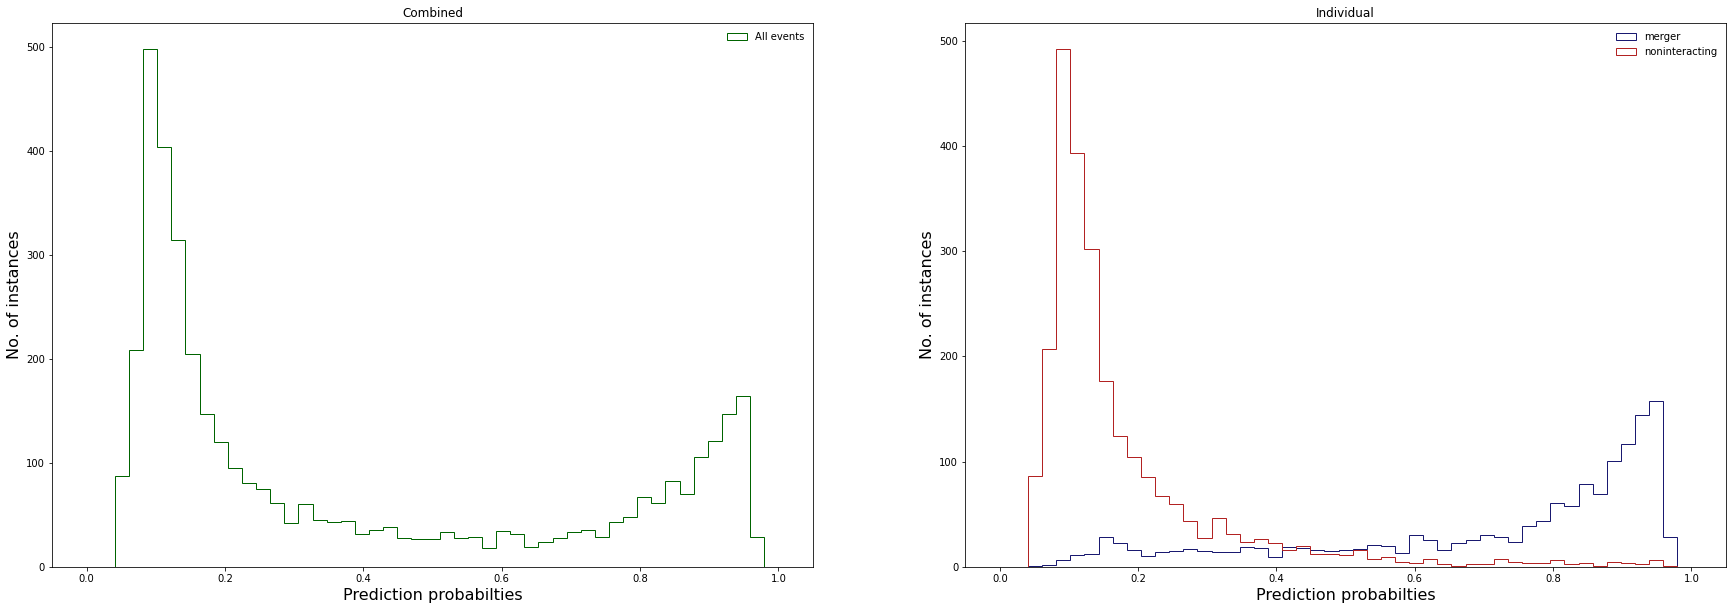

In [ ]:
plot_predictions(predictions, test)

In [ ]:
!pip install plot-metric

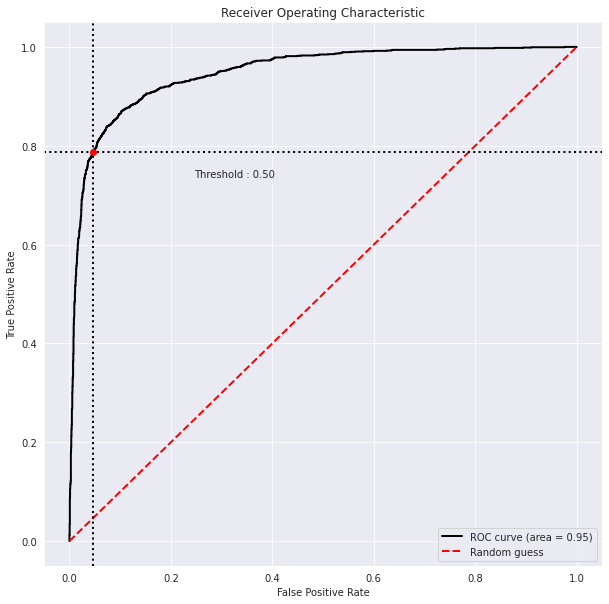

In [ ]:
plot_roc(predictions, test)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score

In [ ]:
final_predictions = np.array([round(pred) for pred in predictions])

In [ ]:
confusion_matrix(test.get_label(), final_predictions)

array([[2384,  116],
       [ 319, 1179]])

In [ ]:
accuracy_score(test.get_label(), final_predictions)

0.8911955977988995

In [ ]:
print(classification_report(test.get_label(), final_predictions))

              precision    recall  f1-score   support

         0.0       0.88      0.95      0.92      2500
         1.0       0.91      0.79      0.84      1498

    accuracy                           0.89      3998
   macro avg       0.90      0.87      0.88      3998
weighted avg       0.89      0.89      0.89      3998



In [ ]:
# # Applying SVM on X_train, y_train data 
# # svm = SVC(kernel='linear', probability=True, random_state=42)
# # svm.fit(X_train, y_train)
# param_dist = {"learning_rate": 0.01, "n_estimators": 600, "reg_lambda": 1e-04, "max_depth": 12, "use_label_encoder": False}  # increasing `max_depth` increases accuracy from ~77 to ~85!
# clf = xgb.XGBRFClassifier(**param_dist)
# clf.fit(np.array(train_data), np.array(train_labels), verbose=True)  # SEE https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor.evals_result FOR better options

# PCA (preparation)

In [ ]:
train_data.shape

(8003, 10000)

In [9]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier

def apply_pca(data, n_components=100):
  scaler = StandardScaler()
  transform_data = scaler.fit_transform(data)
  pca = PCA(n_components=n_components)
  img_pcs = pca.fit_transform(transform_data)  # Image PCs
  # print(f"Explained variance: {np.sum(pca.explained_variance_)}, Explained variance ratio: {pca.explained_variance_ratio_}")
  reconstructed_imgs = pca.inverse_transform(img_pcs)
  explained_variance_ratio = pca.explained_variance_ratio_

  return img_pcs, reconstructed_imgs, explained_variance_ratio


def pca(data, labels, test_data, test_labels, params, model="xgboost", n_components=100, num_trees=200):
  """
  Use the PCA coefficients for training using XGBoost.

  data: Training data for which PCA decomposition needs to be carried out (only features).
  test_data: Testing data (without labels).
  labels: Labels for the data.
  test_labels: Labels for testing data.
  params: Parameters to use in the XGBoost model.
  model: Which model to use for classification with the principal components.
  n_components: No. of components to use for PCA decomposition.
  num_trees: No. of trees to use.

  """
  d = np.vstack([data, test_data])
  train_inds = data.shape[0]
  img_pcs, reconstructed_imgs, exp_var_ratio = apply_pca(d, n_components=n_components)
  # test_img_pcs, _, _ = apply_pca(test_data, n_components=n_components)

  if model == "xgboost":
    train_pca = xgb.DMatrix(img_pcs[:train_inds], label=labels)  # data -> img_pcs, labels -> train_labels
    booster_pca = xgb.train(params, train_pca, num_boost_round=num_trees) # Took 18min 44s

    test_img_pcs, _, _ = apply_pca(img_pcs[train_inds:])
    test_pca = xgb.DMatrix(test_img_pcs, label=test_labels)
    predictions_pca = booster_pca.predict(test_pca)
    booster_pca.save_model("xgboost_pca.txt")
  elif model == "rf":
    rf = RandomForestClassifier()
    rf.fit(img_pcs[:train_inds], labels)
    predictions_pca = rf.predict(img_pcs[train_inds:])

  return img_pcs, reconstructed_imgs, predictions_pca, exp_var_ratio

In [10]:
from sklearn.metrics import precision_recall_fscore_support
def get_statistics_from_preds(predictions, true_labels):
  """
  predictions: The prediction probabilties.
  true_labels: True labels of the test set.

  """
  final_preds = np.rint(predictions)
  acc = accuracy_score(true_labels, final_preds)
  precision, recall, fscore, support = precision_recall_fscore_support(true_labels, final_preds)

  return acc, precision, recall, fscore, support

In [11]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

# PCA + Random Forest on images

In [ ]:
test_data.shape

(3998, 10000)

In [14]:
img_pcs_rf, reconstructed_imgs_rf, predictions_pca_rf, exp_var_ratio_rf = pca(train_data, train_labels, test_data, test_labels, params, model="rf", n_components=0.90)

In [15]:
reconstructed_imgs_rf.shape

(12001, 10000)

In [16]:
train_data.shape

(8003, 10000)

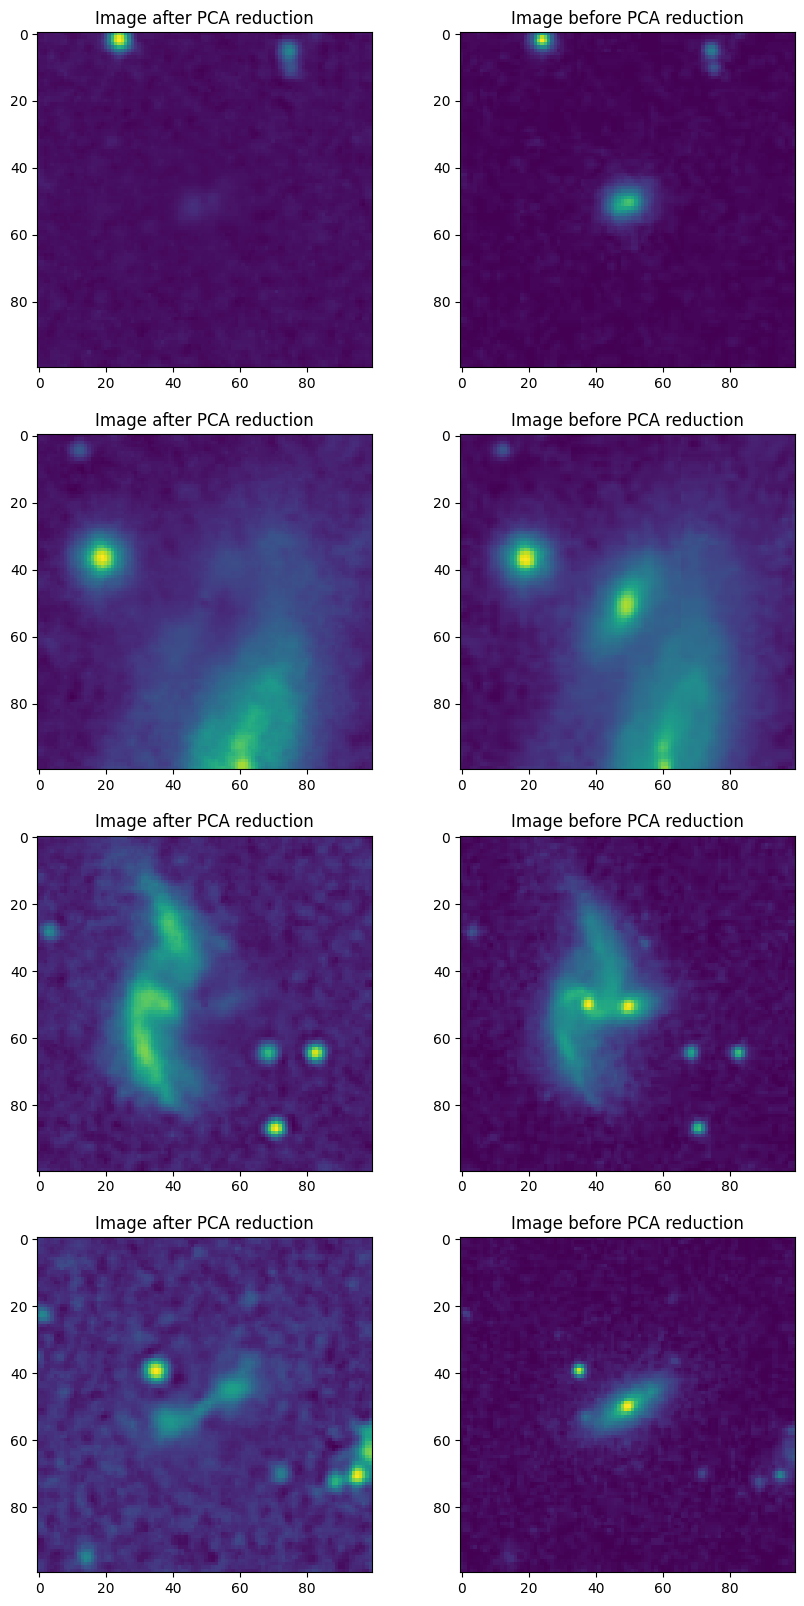

In [17]:
def show_sample_PCA(reconstructed_imgs, train_data):
  # Show sample images
  to_show = 4
  index = np.random.choice(reconstructed_imgs[:train_data.shape[0]].shape[0], to_show, replace=False)
  imgs_random = train_data[index]
  data_show = reconstructed_imgs[index]

  fig, ax = plt.subplots(nrows=to_show, ncols=2, figsize=(10, 20))
  for i in range(len(imgs_random)):
    img = imgs_random[i].reshape(100, 100)  # Since all images are resized to 100 * 100. TODO: Make this robust.
    data_show_img = data_show[i].reshape(100, 100)
    ax[i, 0].imshow(data_show_img)
    ax[i, 0].set_title("Image after PCA reduction")
    ax[i, 1].imshow(img)
    ax[i, 1].set_title("Image before PCA reduction")
  plt.show()

show_sample_PCA(reconstructed_imgs_rf, train_data)

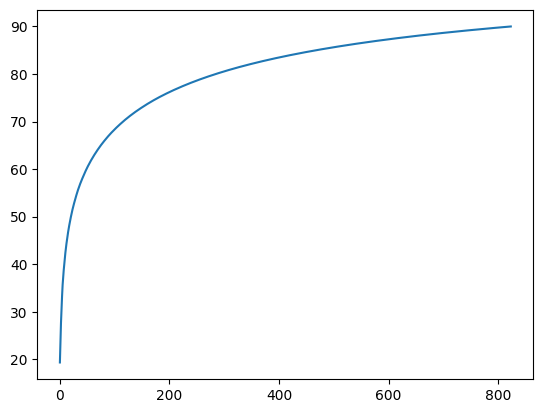

In [ ]:
plt.plot(np.cumsum(exp_var_ratio_rf * 100))
plt.show()

In [ ]:
get_statistics_from_preds(predictions_pca_rf, test_labels)

(0.752376188094047,
 array([0.74770341, 0.76736842]),
 array([0.9116    , 0.48664887]),
 array([0.82155732, 0.59558824]),
 array([2500, 1498]))

# PCA + XGBoost on images

In [ ]:
img_pcs_xgb, reconstructed_imgs_xgb, predictions_pca_xgb, exp_var_ratio_xgb = pca(train_data, train_labels, test_data, test_labels, params, n_components=0.90)

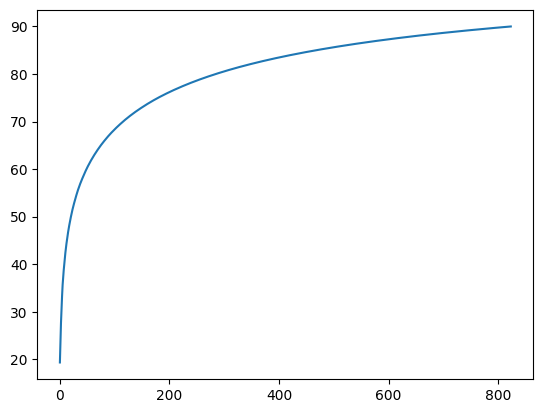

In [ ]:
plt.plot(np.cumsum(exp_var_ratio_xgb * 100))
plt.show()

In [ ]:
get_statistics_from_preds(predictions_pca_xgb, test_labels)

(0.6220610305152576,
 array([0.6259231, 0.4084507]),
 array([0.9832    , 0.01935915]),
 array([0.76489809, 0.03696622]),
 array([2500, 1498]))

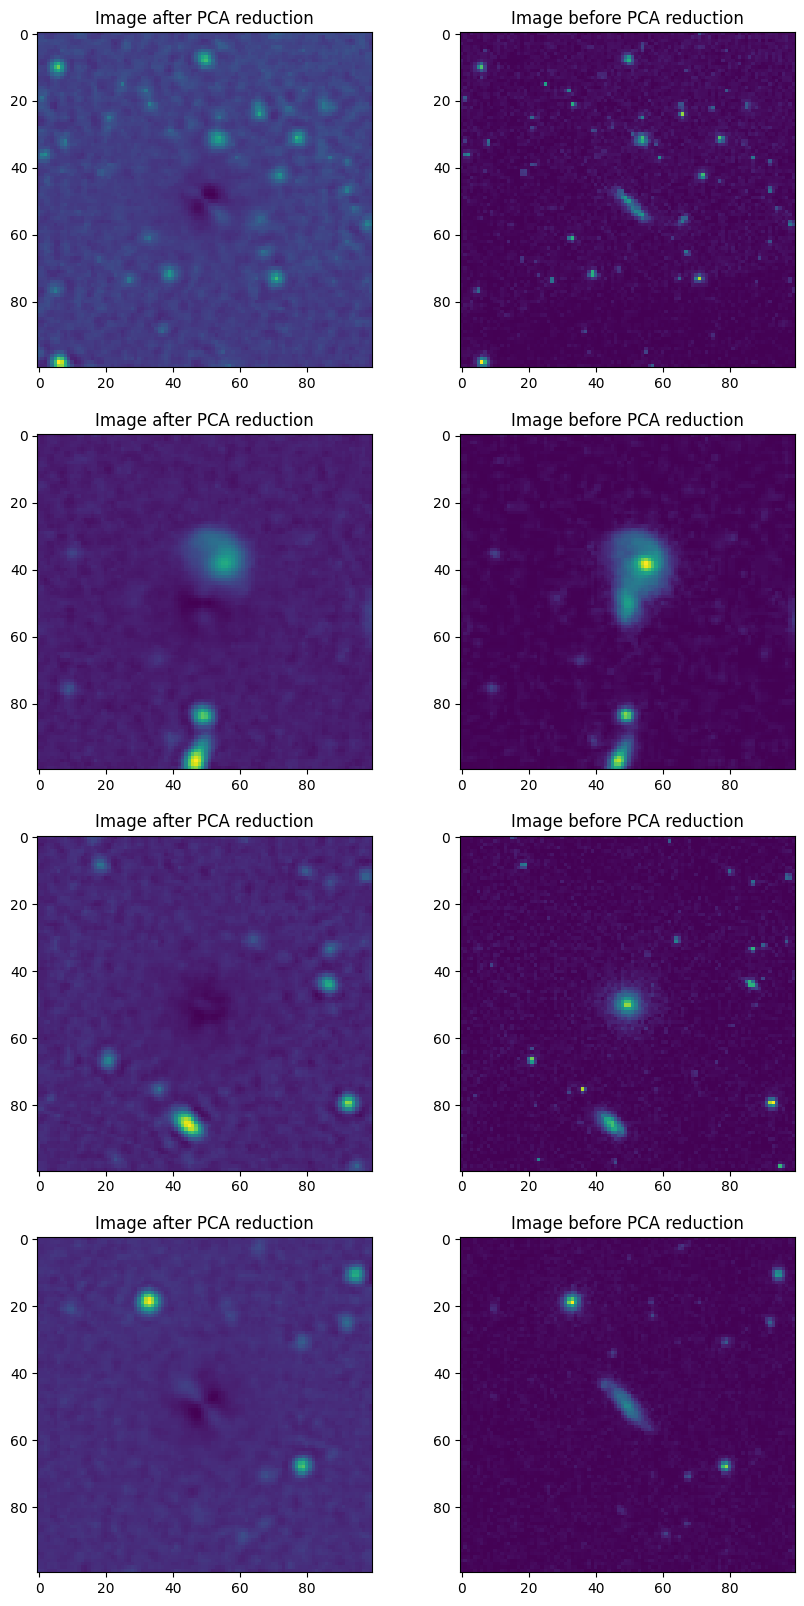

In [ ]:
show_sample_PCA(reconstructed_imgs_xgb, train_data)

### Extra trials

In [ ]:
# n_comps = [100, 500, 1000]
# final_predictions = []
# predictions_probs = []
# for n_comp in n_comps:
#   img_pcs, reconstructed_imgs, predictions_pca, exp_var_ratio = pca(train_data, train_labels, test_data, test_labels, params, n_components=n_comp, num_trees=200)
#   final_preds = np.array([round(pred) for pred in predictions_pca])
#   final_predictions.append(final_preds)
#   predictions_probs.append(predictions_pca)

# final_predictions

In [ ]:
# final_predictions

In [ ]:
# predictions_pca

In [ ]:
# for pred_ in predictions_probs:
#   plot_predictions(pred_, test)

In [ ]:
# for i in range(len(final_predictions)):
#   print(accuracy_score(test.get_label(), final_predictions[i]))
#   print(confusion_matrix(test.get_label(), final_predictions[i]))
#   print("\n")

# FFT

In [ ]:
train_data.shape

(8003, 10000)

In [ ]:
def apply_fft(img_arr_1d):
  """
  img_arr_1d: The flattened 1d image array.

  """
  img_arr_2d = img_arr_1d.reshape(100, 100)
  fft = np.fft.fft2(img_arr_2d)
  fft_feature = np.column_stack([fft.real, fft.imag])
  # print(fft_feature.shape)
  fft_feature = fft_feature.flatten()
  return fft_feature

flattened_fft_data = np.apply_along_axis(apply_fft, 1, train_data)

In [ ]:
list(range(0, 8000, 1000))

[0, 1000, 2000, 3000, 4000, 5000, 6000, 7000]

In [ ]:
list(train_labels).index(0)

3003

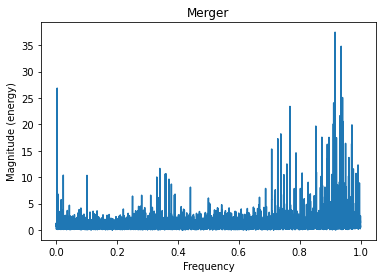

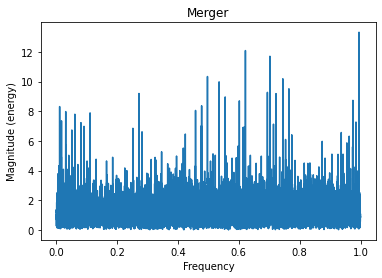

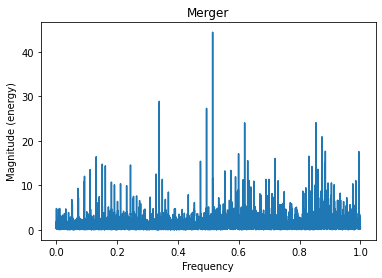

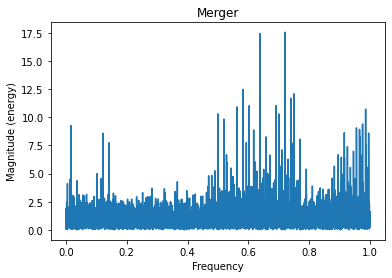

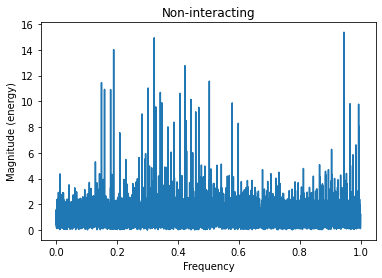

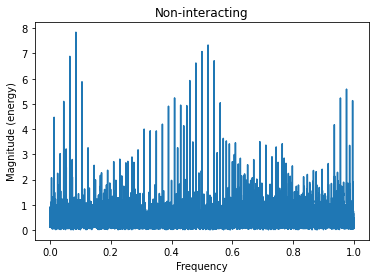

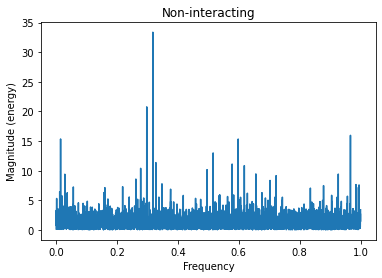

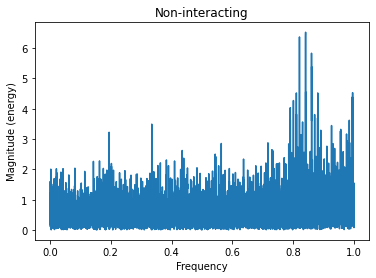

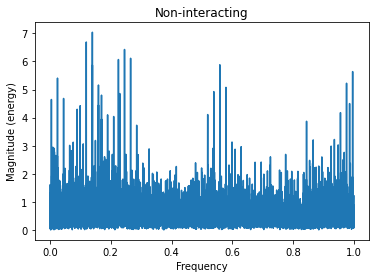

In [ ]:
for i in range(0, 8003, 1000):
  plt.magnitude_spectrum(flattened_fft_data[i])
  if i >= 3003:
    plt.title("Non-interacting")
  else:
    plt.title("Merger")
  plt.show()

In [ ]:
from matplotlib.colors import LogNorm  # Log normalization seems to work the best to visualize FFT features

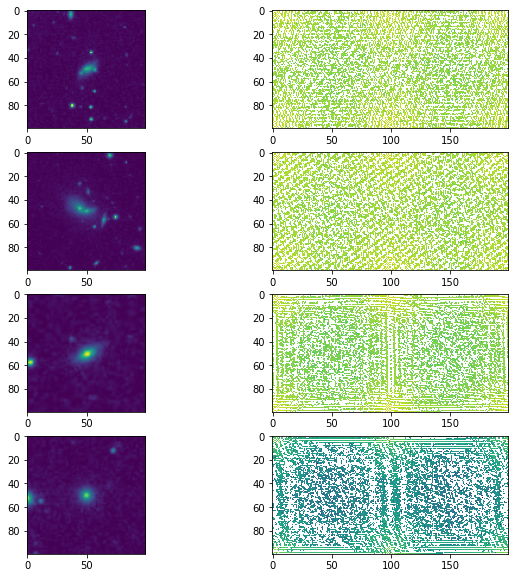

In [ ]:
# Plot some FFT features
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(10, 10))

ax[0, 0].imshow(train_data[0].reshape(100, 100))
ax[0, 1].imshow(flattened_fft_data[0].reshape(100, 200), norm=LogNorm())

ax[1, 0].imshow(train_data[2000].reshape(100, 100))
ax[1, 1].imshow(flattened_fft_data[1].reshape(100, 200), norm=LogNorm())

ax[2, 0].imshow(train_data[5000].reshape(100, 100))
ax[2, 1].imshow(flattened_fft_data[5000].reshape(100, 200), norm=LogNorm())

ax[3, 0].imshow(train_data[8000].reshape(100, 100))
ax[3, 1].imshow(flattened_fft_data[8000].reshape(100, 200), norm=LogNorm())

plt.show()

In [ ]:
flattened_fft_test_data = np.apply_along_axis(apply_fft, 1, test_data)

# FFT + Random Forest

In [ ]:
rf = RandomForestClassifier()
rf.fit(flattened_fft_data, train_labels)
predictions_pca = rf.predict(flattened_fft_test_data)

In [ ]:
get_statistics_from_preds(predictions_pca, test_labels)

(0.768384192096048,
 array([0.77250693, 0.75765766]),
 array([0.8924    , 0.56141522]),
 array([0.8281366 , 0.64493865]),
 array([2500, 1498]))

# FFT + XGBoost

In [ ]:
# num_trees = 200
# fft_train = xgb.DMatrix(flattened_fft_data, label=train_labels)
# fft_test = xgb.DMatrix(flattened_fft_test_data, label=test_labels)
# booster_fft = xgb.train(params, fft_train, num_boost_round=num_trees) # Took 18min 44s

clf = xgb.XGBClassifier(nthread=30)
clf.fit(flattened_fft_data, train_labels)
predictions = clf.predict(flattened_fft_test_data)

/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:18:31] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [ ]:
get_statistics_from_preds(predictions, test_labels)

(0.8379189594797398,
 array([0.83820307, 0.83730159]),
 array([0.918     , 0.70427236]),
 array([0.87628866, 0.76504714]),
 array([2500, 1498]))

# FFT + PCA + XGBoost

This approach might need some investigation.

In [ ]:
img_pcs, reconstructed_imgs, exp_var_ratio = apply_pca(flattened_fft_data, n_components=0.99)

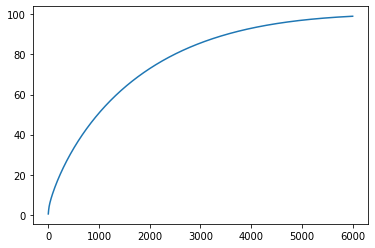

In [ ]:
plt.plot(np.cumsum(exp_var_ratio) * 100);

In [ ]:
train_pcs = xgb.DMatrix(img_pcs, label=train_labels)
booster_pca = xgb.train(params, train_pcs, num_boost_round=200)

In [ ]:
test_img_pcs, _, _ = apply_pca(flattened_fft_test_data, n_components=0.99)
test_pcs = xgb.DMatrix(test_img_pcs, label=test_labels)

In [ ]:
preds_xgb = booster_pca.predict(test_pcs)

In [ ]:
get_statistics_from_preds(preds_xgb, test_labels)

(0.5712856428214107,
 array([0.62258266, 0.36363636]),
 array([0.7984    , 0.19225634]),
 array([0.69961444, 0.25152838]),
 array([2500, 1498]))

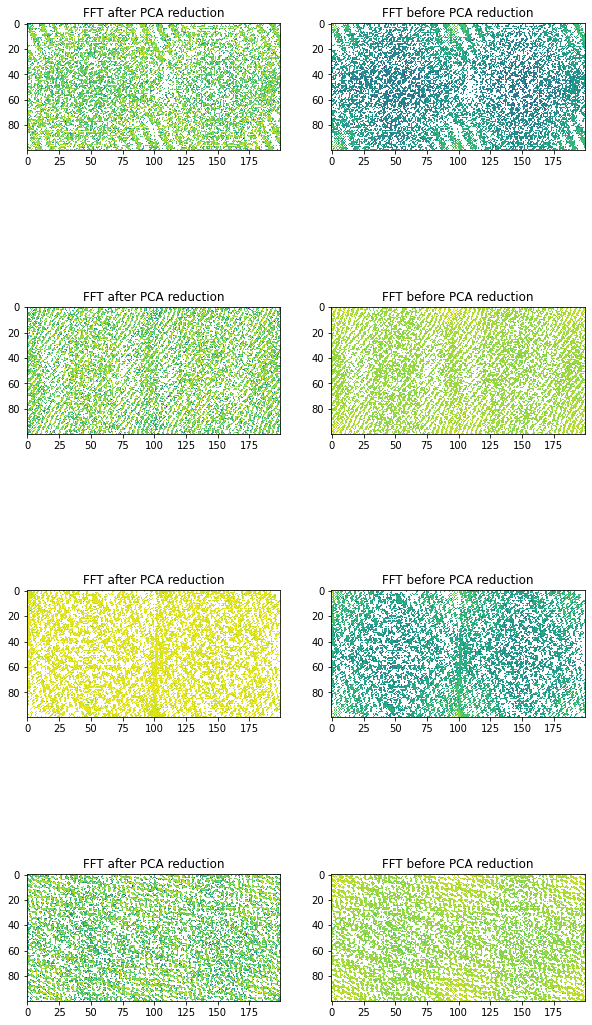

In [ ]:
def show_sample_PCA(reconstructed_fft, train_data):
  # Show sample images
  to_show = 4
  index = np.random.choice(reconstructed_fft[:train_data.shape[0]].shape[0], to_show, replace=False)
  imgs_random = train_data[index]
  data_show = reconstructed_fft[index]

  fig, ax = plt.subplots(nrows=to_show, ncols=2, figsize=(10, 20))
  for i in range(len(imgs_random)):
    img = imgs_random[i].reshape(100, 200)  # Since all images are resized to 100 * 100. TODO: Make this robust.
    data_show_img = data_show[i].reshape(100, 200)
    ax[i, 0].imshow(data_show_img, norm=LogNorm())
    ax[i, 0].set_title("FFT after PCA reduction")
    ax[i, 1].imshow(img, norm=LogNorm())
    ax[i, 1].set_title("FFT before PCA reduction")
  plt.show()

show_sample_PCA(reconstructed_imgs, flattened_fft_data)